In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob
import itertools
from PIL import Image
import pandas as pd

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# prompt: load in files from google drive

from google.colab import drive
drive.mount('/content/drive')
#Example to load a csv
#df = pd.read_csv('/content/drive/My Drive/your_file.csv')
#print(df.head())


In [ ]:
#load in files from gcloud
rna_data = pd.read_csv('/content/drive/My Drive/ML4FGSTABMAP/cleaned_RNA.csv')
colData = pd.read_csv('/content/drive/My Drive/ML4FGSTABMAP/cleaned_colData.csv')
MultiomeData = pd.read_csv('/content/drive/My Drive/ML4FGSTABMAP/cleaned_Multiome.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/ML4FGSTABMAP/cleaned_RNA.csv'

In [ ]:


class BioDataset(torch.utils.data.Dataset):
    def __init__(self, rna_path, mult_path, cell_type_path, is_train):
        self.rna = []
        self.shared = []
        self.mult = []
        self.cell_type = []

        atac_data = pd.read_csv(rna_path, index_col=0)
        mult_data = pd.read_csv(mult_path, index_col=0)
        cell_type = pd.read_csv(cell_type_path, index_col=0)


        # Transpose atac and mult
        atac_data = atac_data.T
        mult_data = mult_data.T

        # Drop the first row
        atac_data = atac_data.iloc[1:]
        mult_data = mult_data.iloc[1:]

        # Join cell_type's broad_celltype to atac_data and mult_data
        atac_data = atac_data.join(cell_type)
        mult_data = mult_data.join(cell_type)

        print(atac_data)

        atac_cell_types = []
        mult_data_cell_types = []

        # Get the broad_celltype column from atac_data and mult_data
        for i in range(len(atac_data)):
            atac_cell_types.append(atac_data.iloc[i]["broad_celltype"])

        for i in range(len(mult_data)):
            mult_data_cell_types.append(mult_data.iloc[i]["broad_celltype"])

        if is_train:
          self.cell_type = atac_cell_types
        else:
          self.cell_type = mult_data_cell_types
        # Print lenght of unique values in cell_type
        print(len(set(self.cell_type)))

        # Drop all cell_type columns from atac_data and mult_data
        atac_data = atac_data.drop(columns=cell_type.columns)
        mult_data = mult_data.drop(columns=cell_type.columns)

        # Convert values to float
        atac_data = atac_data.astype(float)
        mult_data = mult_data.astype(float)

        # Find column names that are shared between atac and mul
        colNames = atac_data.columns.intersection(mult_data.columns)

        # Create colNames only in atac and only in mult
        colNames_atac = atac_data.columns.difference(mult_data.columns)
        colNames_mult = mult_data.columns.difference(atac_data.columns)

        print(len(colNames))
        print(len(colNames_atac))
        print(len(colNames_mult))

        if is_train:
          # Loop through atac_data
          for i in range(len(atac_data)):
              # Add values in atac_data that are not in colNames to rna
              rna_values = atac_data.iloc[i][~atac_data.columns.isin(colNames)].tolist()
              self.rna.append(rna_values)

              # Add values in atac_data that are in colNames to shared
              shared_values = atac_data.iloc[i][atac_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_mult and add to mult
              mult_values = [0] * len(colNames_mult)
              self.mult.append(mult_values)
        else:
          # Loop through mult_data
          for i in range(len(mult_data)):
              # Add values in mult_data that are not in colNames to mult
              mult_values = mult_data.iloc[i][~mult_data.columns.isin(colNames)].tolist()
              self.mult.append(mult_values)

              # Add values in mult_data that are in colNames to shared
              shared_values = mult_data.iloc[i][mult_data.columns.isin(colNames)].tolist()
              self.shared.append(shared_values)

              # Create values of length colNames_atac and add to rna
              rna_values = [0] * len(colNames_atac)
              self.rna.append(rna_values)


        # Check that rna shared mult and cellType have same length
        assert len(self.rna) == len(self.shared)
        assert len(self.rna) == len(self.mult)
        assert len(self.rna) == len(self.cell_type)

        self._check_for_nan()

    def _check_for_nan(self):
        for i in range(len(self.rna)):
            if (np.isnan(self.rna[i]).any() or
                np.isnan(self.shared[i]).any() or
                np.isnan(self.mult[i]).any()):
                raise ValueError(f"NaN value found at index {i}")


    def __len__(self):
        return len(self.rna)

    def __getitem__(self, idx):
        return {
            "rna": self.rna[idx],
            "shared": self.shared[idx],
            "atac": self.mult[idx],
            "cell_type": self.cell_type[idx]
        }

In [ ]:
def collate_fn(batch):
    # Separate the different components of the batch
    rna = [item['rna'] for item in batch]
    shared = [item['shared'] for item in batch]
    atac = [item['atac'] for item in batch]
    cell_types = [item['cell_type'] for item in batch]

    if len(rna[0]) == 0:
      rna = [[-1998] * 25] * len(rna)
    if len(shared[0]) == 0:
      shared = [[-1998] * 25] * len(shared)
    if len(atac[0]) == 0:
      atac = [[-1998] * 25] * len(atac)

    # Convert rna, shared, and atac to tensors of float values
    # Use float32 for better performance, or float64 for higher precision if needed
    rna_tensor = torch.tensor(rna, dtype=torch.float32)
    shared_tensor = torch.tensor(shared, dtype=torch.float32)
    atac_tensor = torch.tensor(atac, dtype=torch.float32)

    # Create attention masks
    # We still use > 0 for the mask, which works for both positive and negative floats
    rna_mask = (rna_tensor != -1998).bool()
    shared_mask = (shared_tensor != -1998).bool()
    atac_mask = (atac_tensor != -1998).bool()

    # Return a dictionary with the tensors, attention masks, and cell types
    return {
        'rna': rna_tensor,
        'rna_attention_mask': rna_mask,
        'shared': shared_tensor,
        'shared_attention_mask': shared_mask,
        'atac': atac_tensor,
        'atac_attention_mask': atac_mask,
        'cell_type': cell_types
    }

In [ ]:
# Create the train/eval/test datasets
train_dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', True)
test_dataset = BioDataset('/content/cleaned_RNA.csv', '/content/cleaned_Multiome.csv', '/content/cleaned_colData.csv', False)
# eval_dataset = BioDataset('./data/dev.jsonl')
# test_dataset = HatefulMemesDataset('./data/test.jsonl', './data')

                  CA6      CNR2    IFNLR1     RCAN3    ZNF683     CSF3R  \
AAACAGCCAATGCGCT  0.0  0.000000  0.000000  2.183987  0.000000  0.000000   
AAACAGCCAGTTTACG  0.0  0.000000  0.000000  1.064252  0.000000  0.000000   
AAACAGCCATCCAGGT  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
AAACATGCAAGGTCCT  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
AAACATGCACTTGTTC  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
...               ...       ...       ...       ...       ...       ...   
TTTGTGGCAGCAACCT  0.0  0.000000  0.000000  0.000000  0.000000  2.091534   
TTTGTGTTCAATTACG  0.0  0.000000  0.000000  0.000000  1.706397  0.000000   
TTTGTGTTCATTGACA  0.0  0.000000  0.000000  0.000000  0.000000  2.527060   
TTTGTGTTCGATAACC  0.0  1.191013  0.000000  0.000000  0.000000  0.000000   
TTTGTGTTCTCCATAT  0.0  0.000000  0.784946  0.000000  0.000000  1.960553   

                     SCMH1    HIVEP3  ZSWIM5  SHISAL2A  ...  KLHL13     TENM1  \
AAACAGCCAATGCGCT  

Split train set into rna and atac embeddings

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

rna_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
multi_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Iterate through the train_loader to access a batch of data
for batch in train_loader:
    # Access the 'rna' data from the batch
    rna_data = batch['rna']
    # Now you can get the shape of the 'rna' data
    print(rna_data.shape)
    # Break the loop after processing one batch if you only need the shape from one batch
    break

torch.Size([16, 25])


In [ ]:
# prompt: generate a PCA visualization of the shared features across the train and test set and color based on cell type

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine the shared features from the train and test sets
train_shared_features = []
train_cell_types = []
for batch in train_loader:
    train_shared_features.extend(batch['shared'].numpy())
    train_cell_types.extend(batch['cell_type'])

test_shared_features = []
test_cell_types = []
for batch in test_loader:
    test_shared_features.extend(batch['shared'].numpy())
    test_cell_types.extend(batch['cell_type'])

combined_features = np.concatenate((train_shared_features, test_shared_features))
combined_cell_types = train_cell_types + test_cell_types

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_result = pca.fit_transform(combined_features)


# Create the PCA visualization
plt.figure(figsize=(8, 6))
for cell_type in set(combined_cell_types):
    indices = [i for i, x in enumerate(combined_cell_types) if x == cell_type]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=cell_type)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Shared Features Colored by Cell Type")
plt.legend()
plt.show()

In [ ]:
import torch

def compute_jaccard_similarity(embeddings_omics1, embeddings_omics2, k=100):
    """
    Computes differentiable Jaccard similarity between nearest neighbors in two omics layers.

    Args:
        embeddings_omics1 (torch.Tensor): Embeddings for omics layer 1 (e.g., RNA).
        embeddings_omics2 (torch.Tensor): Embeddings for omics layer 2 (e.g., chromatin).
        k (int): Number of nearest neighbors to consider (default is 100).

    Returns:
        torch.Tensor: Mean Jaccard similarity across all cells.
    """
    num_cells_omics1 = embeddings_omics1.shape[0]
    num_cells_omics2 = embeddings_omics2.shape[0]

    # Combine embeddings
    combined_embeddings = torch.cat([embeddings_omics1, embeddings_omics2])
    print(combined_embeddings.shape)
    print(embeddings_omics1.shape)
    print(embeddings_omics2.shape)

    # Compute pairwise distances
    distances = torch.cdist(combined_embeddings, combined_embeddings)

    # Get top k nearest neighbors for each cell
    _, neighbors = torch.topk(distances, k=k, largest=False, dim=1)

    jaccard_similarities = []

    for i in range(num_cells_omics1 + num_cells_omics2):
        # Create binary tensors for set representation
        set_omics1 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)
        set_omics2 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)

        # Fill in the sets based on the neighbors
        set_omics1[neighbors[i]] = 1
        set_omics2[neighbors[i]] = 1

        # Adjust sets based on which omics layer the cell belongs to
        if i < num_cells_omics1:
            set_omics1[num_cells_omics1:] = 0
        else:
            set_omics2[:num_cells_omics1] = 0

        # Compute intersection and union
        intersection = torch.min(set_omics1, set_omics2).sum()
        union = torch.max(set_omics1, set_omics2).sum()

        # Compute Jaccard similarity
        jaccard_similarity = intersection / (union + 1e-8)  # Add small epsilon to avoid division by zero
        jaccard_similarities.append(jaccard_similarity)

    # Return the mean Jaccard similarity
    return torch.stack(jaccard_similarities).mean()

In [ ]:
# prompt: set device to gpu

import torch

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Setting device to GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Setting device to CPU.")



GPU is available. Setting device to GPU.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLPVAE(nn.Module):
    def __init__(self, rna_input_dim, shared_input_dim, atac_input_dim, hidden_dim, latent_dim, device='cuda'):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        # Define embedding layers
        self.rna_embedding = nn.Linear(rna_input_dim, hidden_dim)
        self.shared_embedding = nn.Linear(shared_input_dim, hidden_dim)
        self.atac_embedding = nn.Linear(atac_input_dim, hidden_dim)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(rna_input_dim + atac_input_dim + shared_input_dim, hidden_dim),
            nn.ReLU(),
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.ReLU(),
            nn.Linear(3 * hidden_dim, rna_input_dim + shared_input_dim + atac_input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, rna, rna_mask, shared, shared_mask,atac , atac_mask):

        rna = rna.to(self.device)
        shared = shared.to(self.device)
        atac = atac.to(self.device)

        shared_mask = shared_mask.to(self.device)
        atac_mask = atac_mask.to(self.device)
        rna_mask = rna_mask.to(self.device)
        rna = rna.unsqueeze(-1)
        shared = shared.unsqueeze(-1)
        atac = atac.unsqueeze(-1)

        # Normalize inputs
        rna = (rna - rna.mean(dim=1, keepdim=True)) / (rna.std(dim=1, keepdim=True) + 1e-8)
        shared = (shared - shared.mean(dim=1, keepdim=True)) / (shared.std(dim=1, keepdim=True) + 1e-8)
        atac = (atac - atac.mean(dim=1, keepdim=True)) / (atac.std(dim=1, keepdim=True) + 1e-8)

        rna = rna * rna_mask.unsqueeze(-1)
        shared = shared * shared_mask.unsqueeze(-1)
        atac = atac * atac_mask.unsqueeze(-1)

        # Embed and concatenate inputs
        rna_emb = self.rna_embedding(rna.squeeze(-1))
        shared_emb = self.shared_embedding(shared.squeeze(-1))
        atac_emb = self.atac_embedding(atac.squeeze(-1))
        x = torch.cat([rna_emb, shared_emb, atac_emb], dim=1)
        mask= torch.cat([rna_mask, shared_mask, atac_emb], dim=1)

        return x


In [ ]:
for batch in train_loader:
    rna_tensor = batch['rna']
    atac_tensor = batch['atac']
    shared_tensor = batch['shared']
    break
for batch in train_loader:
    rna_input_dim = batch['rna'].shape[1]
    shared_input_dim = batch['shared'].shape[1]
    atac_input_dim = batch['atac'].shape[1]
    break
hidden_dim = 4
latent_dim = 32
embedding_size = 2  # Replace with the actual number of cell types
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance and move to device
model = MLPVAE(rna_input_dim, shared_input_dim, atac_input_dim, hidden_dim, latent_dim).to(device)
model = model.to(device)
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
jaccard_weight = 0  # Weight for Jaccard similarity in the loss function

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_logits, train_labels)
    predictions = knn.predict(test_logits)
    return accuracy_score(test_labels, predictions)

In [ ]:

import torch

def compute_jaccard_similarity(embeddings_omics1, embeddings_omics2, k=100):
    """
    Computes differentiable Jaccard similarity between nearest neighbors in two omics layers.

    Args:
        embeddings_omics1 (torch.Tensor): Embeddings for omics layer 1 (e.g., RNA).
        embeddings_omics2 (torch.Tensor): Embeddings for omics layer 2 (e.g., chromatin).
        k (int): Number of nearest neighbors to consider (default is 100).

    Returns:
        torch.Tensor: Mean Jaccard similarity across all cells.
    """
    num_cells_omics1 = embeddings_omics1.shape[0]
    num_cells_omics2 = embeddings_omics2.shape[0]

    # Combine embeddings
    combined_embeddings = torch.cat([embeddings_omics1, embeddings_omics2])

    # Compute pairwise distances
    distances = torch.cdist(combined_embeddings, combined_embeddings)

    # Get top k nearest neighbors for each cell
    _, neighbors = torch.topk(distances, k=k, largest=False, dim=1)

    jaccard_similarities = []

    for i in range(num_cells_omics1 + num_cells_omics2):
        # Create binary tensors for set representation
        set_omics1 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)
        set_omics2 = torch.zeros(num_cells_omics1 + num_cells_omics2, device=embeddings_omics1.device)

        # Fill in the sets based on the neighbors
        set_omics1[neighbors[i]] = 1
        set_omics2[neighbors[i]] = 1

        # Adjust sets based on which omics layer the cell belongs to
        if i < num_cells_omics1:
            set_omics1[num_cells_omics1:] = 0
        else:
            set_omics2[:num_cells_omics1] = 0

        # Compute intersection and union
        intersection = torch.min(set_omics1, set_omics2).sum()
        union = torch.max(set_omics1, set_omics2).sum()

        # Compute Jaccard similarity
        jaccard_similarity = intersection / (union + 1e-8)  # Add small epsilon to avoid division by zero
        jaccard_similarities.append(jaccard_similarity)

    # Return the mean Jaccard similarity
    return torch.stack(jaccard_similarities).mean()

In [ ]:

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

for batch in train_loader:
    rna_tensor = batch['rna']
    atac_tensor = batch['atac']
    shared_tensor = batch['shared']
    break
for batch in train_loader:
    rna_input_dim = batch['rna'].shape[1]
    shared_input_dim = batch['shared'].shape[1]
    atac_input_dim = batch['atac'].shape[1]
    break
hidden_dim = 4
latent_dim = 32
embedding_size = 2  # Replace with the actual number of cell types
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance and move to device
model = MLPVAE(rna_input_dim, shared_input_dim, atac_input_dim, hidden_dim, latent_dim).to(device)
model = model.to(device)
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
jaccard_weight = 0  # Weight for Jaccard similarity in the loss function

# Initialize lists to collect logits and labels
train_logits_list = []
train_labels_list = []

# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Lists to store loss values for plotting
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    train_logits = []
    train_labels = []
    model.train()
    total_loss = 0

    # Training Phase
    for batch in train_loader:
        optimizer.zero_grad()
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        cell_types = batch['cell_type']
        rna_mask = batch['rna_attention_mask'].to(device)
        atac_mask = batch['atac_attention_mask'].to(device)
        shared_mask = batch['shared_attention_mask'].to(device)
        # Convert string labels to numerical format
        unique_labels = list(set(cell_types))  # Ensure consistent label mapping across batches
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)
        # Get logits
        x = model.forward(rna_tensor,rna_mask, shared_tensor,shared_mask, atac_tensor,atac_mask)

        # Compute cross-entropy loss
        loss = criterion(x, numerical_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect logits and labels for KNN accuracy computation
        train_logits_list.append(x.cpu().detach().numpy())
        train_labels_list.extend(cell_types)

    # Print epoch results
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}")

# After training, concatenate logits and labels

train_labels = np.array([label_to_index[label] for label in train_labels_list])
train_logits = np.concatenate(train_logits_list, axis=0)

print("Training completed!")

# Testing Phase
model.eval()
total_test_loss = 0
test_logits_list = []
test_labels_list = []

with torch.no_grad():
    for batch in test_loader:
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        cell_types = batch['cell_type']
        rna_mask = batch['rna_attention_mask'].to(device)
        atac_mask = batch['atac_attention_mask'].to(device)
        shared_mask = batch['shared_attention_mask'].to(device)


        # Convert string labels to numerical format
        numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)

        # Forward pass
        x = model.forward(rna_tensor,rna_mask, shared_tensor,shared_mask, atac_tensor,atac_mask)
        x_array= np.array(x.cpu().detach().numpy())
        loss = criterion(x, numerical_labels)

        total_test_loss += loss.item()
        test_logits_list.append(x.cpu().detach().numpy())
        test_labels_list.extend(cell_types)
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Test Loss: {avg_test_loss:.4f}")
test_logits = np.concatenate(test_logits_list, axis=0)
test_labels = np.array([label_to_index[label] for label in test_labels_list])
test_labels_list = np.array(test_labels)
test_logits_list = np.array(test_logits)
train_logits_list = np.array(train_logits)
train_labels_list = np.array(train_labels)

knn_accuracy = compute_knn_accuracy(train_logits_list, train_labels_list, test_logits, test_labels_list)
print(knn_accuracy)
train_logits_tensor = torch.tensor(train_logits_list,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_list)
test_logits_tensor = torch.tensor(test_logits_list)
jaccard_score = compute_jaccard_similarity(train_logits_tensor, test_logits_tensor)
print(jaccard_score)






Epoch [1/10] - Train Loss: 2.0863
Epoch [2/10] - Train Loss: 1.9745
Epoch [3/10] - Train Loss: 1.9257
Epoch [4/10] - Train Loss: 1.8812
Epoch [5/10] - Train Loss: 1.8399
Epoch [6/10] - Train Loss: 1.7987
Epoch [7/10] - Train Loss: 1.7573
Epoch [8/10] - Train Loss: 1.7182
Epoch [9/10] - Train Loss: 1.6805
Epoch [10/10] - Train Loss: 1.6435
Training completed!
Test Loss: 1.7146
0.7278201525491771
tensor(0.9762)


Epoch [1/10] - Train Loss: 2.1900, Test Loss: 2.1235
Epoch [2/10] - Train Loss: 2.0952, Test Loss: 2.0710
Epoch [3/10] - Train Loss: 2.0465, Test Loss: 2.0248
Epoch [4/10] - Train Loss: 2.0007, Test Loss: 1.9808
Epoch [5/10] - Train Loss: 1.9580, Test Loss: 1.9382
Epoch [6/10] - Train Loss: 1.9159, Test Loss: 1.8968
Epoch [7/10] - Train Loss: 1.8745, Test Loss: 1.8565
Epoch [8/10] - Train Loss: 1.8346, Test Loss: 1.8172
Epoch [9/10] - Train Loss: 1.7963, Test Loss: 1.7788
Epoch [10/10] - Train Loss: 1.7577, Test Loss: 1.7413
KNN Accuracy: 0.7314
Jaccard Score: 0.9596


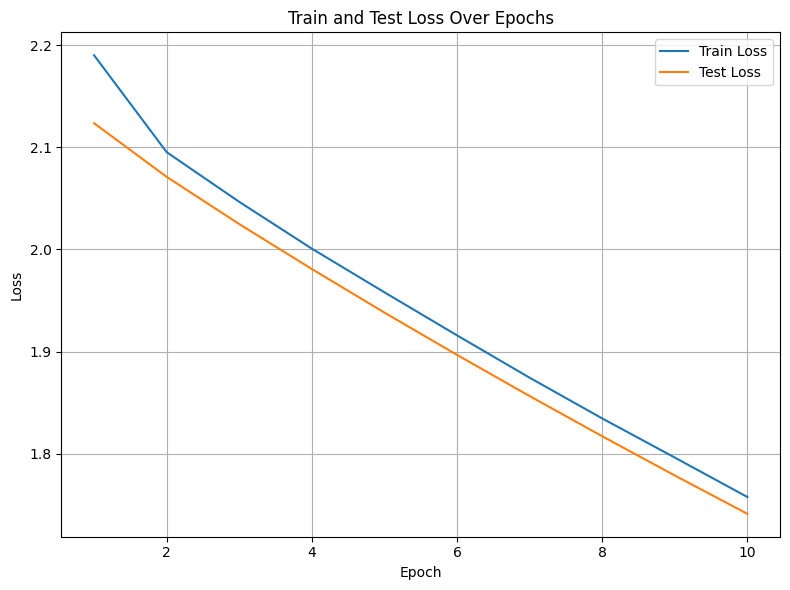

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Initialize dimensions
for batch in train_loader:
    rna_input_dim = batch['rna'].shape[1]
    shared_input_dim = batch['shared'].shape[1]
    atac_input_dim = batch['atac'].shape[1]
    break

hidden_dim = 4
latent_dim = 32
learning_rate = 1e-4
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance and move to device
model = MLPVAE(rna_input_dim, shared_input_dim, atac_input_dim, hidden_dim, latent_dim).to(device)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Initialize lists for tracking
train_losses = []
test_losses = []

train_logits_list = []
train_labels_list = []

# Training and Testing Loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        rna_mask = batch['rna_attention_mask'].to(device)
        atac_mask = batch['atac_attention_mask'].to(device)
        shared_mask = batch['shared_attention_mask'].to(device)
        cell_types = batch['cell_type']

        # Convert labels to numerical format
        unique_labels = list(set(cell_types))  # Ensure consistent label mapping
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)

        # Forward pass
        logits = model.forward(rna_tensor, rna_mask, shared_tensor, shared_mask, atac_tensor, atac_mask)
        loss = criterion(logits, numerical_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_logits_list.append(logits.cpu().detach().numpy())
        train_labels_list.extend(cell_types)

    # Average train loss for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Testing phase within the epoch
    model.eval()
    total_test_loss = 0
    test_logits_list = []
    test_labels_list = []

    with torch.no_grad():
        for batch in test_loader:
            rna_tensor = batch['rna'].to(device)
            atac_tensor = batch['atac'].to(device)
            shared_tensor = batch['shared'].to(device)
            rna_mask = batch['rna_attention_mask'].to(device)
            atac_mask = batch['atac_attention_mask'].to(device)
            shared_mask = batch['shared_attention_mask'].to(device)
            cell_types = batch['cell_type']

            # Convert labels to numerical format
            numerical_labels = torch.tensor([label_to_index[label] for label in cell_types], device=device)

            # Forward pass
            logits = model.forward(rna_tensor, rna_mask, shared_tensor, shared_mask, atac_tensor, atac_mask)
            loss = criterion(logits, numerical_labels)
            total_test_loss += loss.item()

            test_logits_list.append(logits.cpu().detach().numpy())
            test_labels_list.extend(cell_types)

    # Average test loss for this epoch
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Concatenate logits and labels after training
train_logits = np.concatenate(train_logits_list, axis=0)
train_labels = np.array([label_to_index[label] for label in train_labels_list])
test_logits = np.concatenate(test_logits_list, axis=0)
test_labels = np.array([label_to_index[label] for label in test_labels_list])

# Compute KNN accuracy
knn_accuracy = compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels)
print(f"KNN Accuracy: {knn_accuracy:.4f}")

# Convert logits to tensors for Jaccard similarity
train_logits_tensor = torch.tensor(train_logits, dtype=torch.float32)
test_logits_tensor = torch.tensor(test_logits, dtype=torch.float32)
jaccard_score = compute_jaccard_similarity(train_logits_tensor, test_logits_tensor)
print(f"Jaccard Score: {jaccard_score:.4f}")
rna_embedding = model.rna_embedding
shared_embedding = model.shared_embedding
atac_embedding = model.atac_embedding

# Plot train and test loss curves without markers
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Train and Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: print the number of parameters in my model

import torch

# Assuming 'model' is your defined MLPVAE model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"The model has {params} trainable parameters.")

The model has 37593 trainable parameters.


In [ ]:
rna_embeddings_list = []
multi_embeddings_list = []
# Process RNA data
for batch in rna_loader:
    rna = batch['rna']
    rna_mask = batch['rna_attention_mask']
    shared = batch['shared']
    shared_mask = batch['shared_attention_mask']
    atac = batch['atac']  # Placeholder for atac in RNA data
    atac_mask = batch['atac_attention_mask']  # Placeholder for atac mask
    embeddings = model(rna, rna_mask, shared, shared_mask, atac, atac_mask)
    rna_embeddings_list.append(embeddings.cpu().detach().numpy())

# Process Multiome data
for batch in multi_loader:
    rna = batch['rna']  # Placeholder for rna in Multiome data
    rna_mask = batch['rna_attention_mask']  # Placeholder for rna mask
    shared = batch['shared']
    shared_mask = batch['shared_attention_mask']
    atac = batch['atac']
    atac_mask = batch['atac_attention_mask']
    embeddings = model(rna, rna_mask, shared, shared_mask, atac, atac_mask)
    multi_embeddings_list.append(embeddings.cpu().detach().numpy())


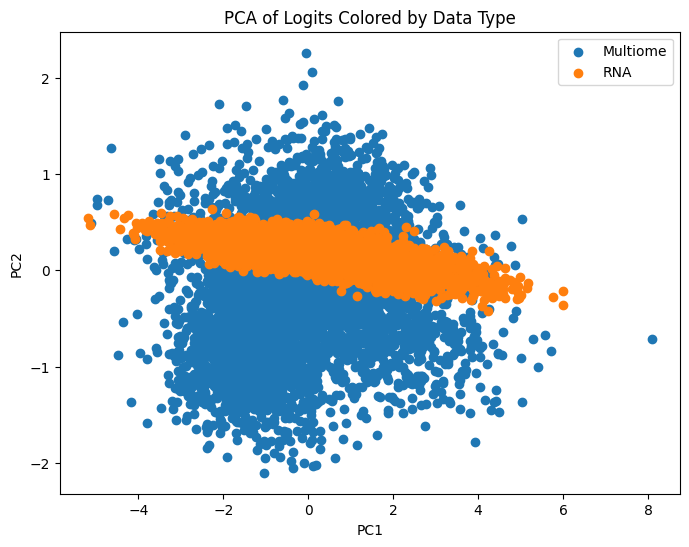

In [ ]:
# prompt: run pca on my logits and color based on whether multiome or atac

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Concatenate embeddings and create labels
all_embeddings = np.concatenate([np.concatenate(rna_embeddings_list), np.concatenate(multi_embeddings_list)])
labels = ['RNA'] * len(np.concatenate(rna_embeddings_list)) + ['Multiome'] * len(np.concatenate(multi_embeddings_list))

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings)

# Create the scatter plot
plt.figure(figsize=(8, 6))
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Logits Colored by Data Type")
plt.legend()
plt.show()

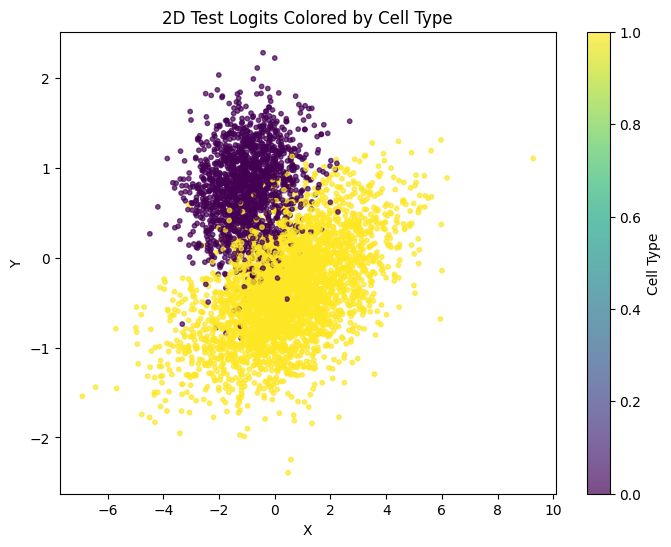

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'test_logits' and 'test_labels' are available from the training loop
# and are numpy arrays of shape (num_samples, embedding_dim) and (num_samples,) respectively.

# Reduce dimensionality for plotting if needed (e.g., using PCA)
test_logits_2d = test_logits
if test_logits.shape[1] > 2:
    pca = PCA(n_components=2)
    test_logits_2d = pca.fit_transform(test_logits)

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(test_labels)

# Create the plot
plt.figure(figsize=(8, 6))

# Use numerical labels for coloring the points
scatter = plt.scatter(test_logits_2d[:, 0], test_logits_2d[:, 1], c=numerical_labels, cmap='viridis', alpha=0.7, s=10)

# Add colorbar to show the mapping between colors and labels
plt.colorbar(scatter, label='Cell Type')


# Add labels, title and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Test Logits Colored by Cell Type")


# Show the plot
plt.show()

In [ ]:

def compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_logits, train_labels)
    predictions = knn.predict(test_logits)
    return accuracy_score(test_labels, predictions)

In [ ]:
# Initialize lists to store metrics and data
train_losses = []
test_losses = []
latent_representations = []
all_cell_types = []
logits_list = []  # List to store logits

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Move tensors to device
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        cell_types = batch['cell_type']

        # Encode cell types
        cell_types_encoded = label_encoder.transform(cell_types)
        cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

        # Concatenate input data
        input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

        # Forward pass
        recon_x, mu, log_var = model(input_data)

        # Get logits from the model
        logits_mu, logits_log_var = model.get_logits(input_data)

        # Compute losses
        vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
        s_nn_loss = soft_nearest_neighbor_loss(logits_mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
        loss = vae_loss + s_nn_loss

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping this batch.")
            continue

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Store latent representations and cell types
        latent_representations.append(mu.cpu().detach().numpy())
        all_cell_types.append(cell_types_encoded)

        # Accumulate batch loss
        epoch_train_loss += loss.item()

    # Store average train loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Evaluation phase (on the test set)
    model.eval()  # Set model to evaluation mode
    epoch_test_loss = 0
    all_latent_reps = []
    all_test_cell_types = []
    all_logits = []  # List to store logits during evaluation

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in test_loader:
            # Move tensors to device
            rna_tensor = batch['rna'].to(device)
            atac_tensor = batch['atac'].to(device)
            shared_tensor = batch['shared'].to(device)
            cell_types = batch['cell_type']

            # Encode cell types using the same label encoder
            cell_types_encoded = label_encoder.transform(cell_types)
            cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

            # Prepare input data
            input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

            # Forward pass
            recon_x, mu, log_var = model(input_data)

            # Get logits from the model
            logits_mu, logits_log_var = model.get_logits(input_data)

            # Compute losses
            vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
            s_nn_loss = soft_nearest_neighbor_loss(logits_mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
            loss = vae_loss + s_nn_loss
            epoch_test_loss += loss.item()

            # Store latent representations, logits, and true labels
            all_latent_reps.append(mu.cpu().detach().numpy())
            all_test_cell_types.extend(cell_types_encoded)  # Use extend to avoid nested lists
            all_logits.append(logits_mu.cpu().detach().numpy())  # Logits are the raw outputs from the model

        # Average test loss
        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

# Combine all latent representations and cell types for PCA and classification
latent_representations = np.vstack(latent_representations)
all_cell_types = np.concatenate(all_cell_types)

# Combine all logits (no need to apply softmax yet)
logits_list = np.vstack(all_logits)

# Return test labels and logits
test_labels = np.array(all_test_cell_types)

# Print shapes for verification
print(f"Test Labels shape: {test_labels.shape}")
print(f"Logits shape: {logits_list.shape}")


In [ ]:
# prompt: generate a PCA of the logits returned from get_logits

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'logits_list' and 'test_labels' are available from the previous code

# Apply PCA to the logits
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_result = pca.fit_transform(logits_list)

# Create the PCA visualization
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=test_labels, cmap='viridis', alpha=0.7)
plt.title('PCA of Logits Colored by Cell Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cell Type')
plt.grid(True)
plt.show()

In [ ]:
# prompt: generate a PCA of logits and color them based on cell type dont use cmap_ label them as Lymphoid or Myeloid use matplotlib not seaborn

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'logits_list' and 'test_labels' are available from the previous code

# Apply PCA to the logits
pca = PCA(n_components=2)  # Reduce to 2 principal components for visualization
pca_result = pca.fit_transform(logits_list)

# Create a mapping for cell type labels (replace with your actual labels)
cell_type_mapping = {
    0: "Lymphoid",  # Example mapping for class 0
    1: "Myeloid"   # Example mapping for class 1
    # ... add other mappings as needed
}

# Map the numerical cell type labels to the new labels
mapped_labels = [cell_type_mapping.get(label, "Unknown") for label in test_labels]

# Create the PCA visualization with the specified colors and labels
plt.figure(figsize=(10, 6))

# Scatter plot with color mapping
for label_value, label_name in cell_type_mapping.items():
  indices = [i for i, label in enumerate(test_labels) if label == label_value]
  plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label_name, alpha=0.7)

plt.title('PCA of Logits Colored by Cell Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()  # Add the legend to show the cell type labels
plt.grid(True)
plt.show()

In [ ]:
# prompt: evaluate the knn_accuracy of the embedding

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming you have train_logits, train_labels, test_logits, and test_labels
# Replace these placeholders with your actual data

# Example usage (assuming mu is your embedding):
train_logits = latent_representations[:len(train_dataset)]
train_labels = all_cell_types[:len(train_dataset)]

# Evaluate the knn accuracy on the test set
test_logits = latent_representations[len(train_dataset):]
test_labels = all_cell_types[len(train_dataset):]


knn_accuracy = compute_knn_accuracy(train_logits, train_labels, test_logits, test_labels, k=5)
print(f"KNN accuracy on test set: {knn_accuracy}")

In [ ]:
# prompt: visualize the embedding

import matplotlib.pyplot as plt

# Assuming 'mu' contains the embeddings from the last batch of your training loop
# You'll need to collect embeddings from all batches if you want to visualize the entire dataset

# Get the embeddings and corresponding cell types from the last batch
embeddings = mu.cpu().detach().numpy() # Move embeddings to CPU and detach from computation graph
cell_types = np.array(cell_types) # Convert cell_types to a NumPy array

# Create the plot
plt.figure(figsize=(10, 8))
for cell_type in np.unique(cell_types):
    indices = np.where(cell_types == cell_type)
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=str(cell_type))

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")  # Adjust based on your embedding dimensions
plt.title("Visualization of Cell Type Embeddings")
plt.legend()
plt.show()

In [ ]:
# prompt: Print total number of parameters in model

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

We are training on the multimodal data, test on atac_seq, need to add loss function

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize lists to store metrics and data
train_losses = []
test_losses = []
latent_representations = []
all_cell_types = []
logits_list = []  # List to store logits

# Initialize optimizer and label encoder
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
label_encoder = LabelEncoder()

# Fit label encoder on all unique cell types
all_unique_cell_types = np.unique(train_dataset.cell_type)
label_encoder.fit(all_unique_cell_types)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Move tensors to device
        rna_tensor = batch['rna'].to(device)
        atac_tensor = batch['atac'].to(device)
        shared_tensor = batch['shared'].to(device)
        cell_types = batch['cell_type']

        # Encode cell types
        cell_types_encoded = label_encoder.transform(cell_types)
        cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

        # Concatenate input data
        input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

        # Forward pass
        recon_x, mu, log_var = model(input_data)

        # Get logits from the model
        logits_mu, logits_log_var = model.get_logits(input_data)

        # Compute losses
        vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
        s_nn_loss = soft_nearest_neighbor_loss(logits_mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
        loss = vae_loss + s_nn_loss

        # Check for NaN in loss
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping this batch.")
            continue

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Store latent representations and cell types
        latent_representations.append(mu.cpu().detach().numpy())
        all_cell_types.append(cell_types_encoded)

        # Store logits
        logits_list.append(logits_mu.cpu().detach().numpy())

        # Accumulate batch loss
        epoch_train_loss += loss.item()

    # Store average train loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Evaluation phase (on the test set)
    model.eval()  # Set model to evaluation mode
    epoch_test_loss = 0
    all_latent_reps = []
    all_test_cell_types = []
    all_logits = []  # List to store logits during evaluation

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in test_loader:
            # Move tensors to device
            rna_tensor = batch['rna'].to(device)
            atac_tensor = batch['atac'].to(device)
            shared_tensor = batch['shared'].to(device)
            cell_types = batch['cell_type']

            # Encode cell types using the same label encoder
            cell_types_encoded = label_encoder.transform(cell_types)
            cell_types_tensor = torch.tensor(cell_types_encoded, dtype=torch.long, device=device)

            # Prepare input data
            input_data = torch.cat([rna_tensor, atac_tensor, shared_tensor], dim=1)

            # Forward pass
            recon_x, mu, log_var = model(input_data)

            # Get logits from the model
            logits_mu, logits_log_var = model.get_logits(input_data)

            # Compute losses
            vae_loss = vae_loss_function(recon_x, input_data, mu, log_var)
            s_nn_loss = soft_nearest_neighbor_loss(logits_mu, cell_types_tensor, temperature=0.1, num_neighbors=5)
            loss = vae_loss + s_nn_loss
            epoch_test_loss += loss.item()

            # Store latent representations, logits, and true labels
            all_latent_reps.append(mu.cpu().detach().numpy())
            all_test_cell_types.extend(cell_types_encoded)  # Use extend to avoid nested lists
            all_logits.append(logits_mu.cpu().detach().numpy())  # Logits are the raw outputs from the model

        # Average test loss
        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

# Combine all latent representations and cell types for PCA and classification
latent_representations = np.vstack(all_latent_reps)
all_cell_types = np.concatenate(all_test_cell_types)

# Combine all logits (no need to apply softmax yet)
logits_list = np.vstack(all_logits)

# Return test labels and logits
test_labels = np.array(all_test_cell_types)

# Print shapes for verification
print(f"Test Labels shape: {test_labels.shape}")
print(f"Logits shape: {logits_list.shape}")

# Plot train and test losses using Seaborn
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='b')  # Removed marker='o'
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='r')  # Removed marker='o'
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# PCA visualization using Seaborn
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_representations)

# Convert cell types to categorical values for distinct color mapping
cell_types_categorical = label_encoder.inverse_transform(all_cell_types.astype(int))  # Convert to int before inverse_transform

# Now use cell_types_categorical for hue in sns.scatterplot
plt.figure(figsize=(10, 6))
# Convert cell types to string to avoid hue issue
cell_types_categorical = [str(cell_type) for cell_type in cell_types_categorical]
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cell_types_categorical, palette={'Lymphoid': 'red', 'Myeloid': 'blue'}, alpha=0.7)
plt.title('2D PCA of Latent Representations Colored by Cell Type')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Optional: Classification on latent space (e.g., k-NN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(latent_representations, all_cell_types)  # Use latent_representations for fitting
predicted_labels = knn.predict(latent_representations)

# Calculate accuracy
accuracy = accuracy_score(all_cell_types, predicted_labels)
print(f"Test Accuracy (k-NN on Latent Space): {accuracy:.4f}")

# Calculate jaccard similarity
from sklearn.metrics import jaccard_score
jaccard_sim = jaccard_score(all_cell_types, predicted_labels, average='weighted')
print(f"Jaccard Similarity: {jaccard_sim:.4f}")
